In [1]:
%matplotlib inline

In [2]:
from gpitch.matern12_spectral_mixture import MercerMatern12sm
from gpitch.myplots import plot_predict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpitch
import gpflow

In [3]:
# gpu usage
gpitch.init_settings();
plt.rcParams["figure.figsize"] = (12, 4)

In [4]:
# load audio
path = "../data/"
fname = "011PFNOF_M60_train.wav"
x, y, fs = gpitch.readaudio(path + fname)
f0 = gpitch.find_ideal_f0([fname])
print f0

[261.6255653005986]


number of inducing variables 109


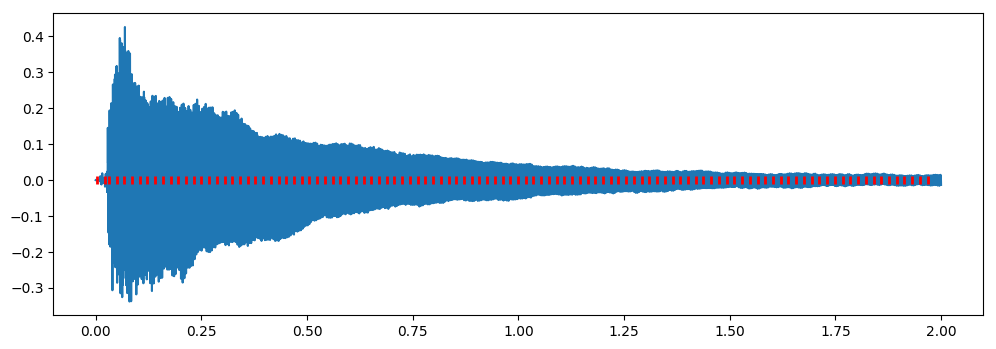

In [5]:
#  use maxima as inducing points
z, u = gpitch.init_liv(x=x, y=y, win_size=31, thres=0.033, dec=9)
print("number of inducing variables {0}".format(u.size))

plt.figure()
plt.plot(x, y)
plt.plot(z[0][0], 0.*u, '|r', mfc="none", ms=6, mew=2)

In [6]:
# init activation kernel
kact = gpflow.kernels.Matern32(input_dim=1, lengthscales=1.0, variance=1.0)

# init component kernel
npartials = 5
enr = np.ones((npartials))
frq = f0*np.array(range(1, npartials + 1))
kcom = MercerMatern12sm(input_dim=1, energy=enr, frequency=frq)
kern = [[kact], [kcom]]

In [7]:
# init model
m = gpitch.pdgp.Pdgp(x=x.copy(), y=y.copy(), z=z, kern=kern, minibatch_size=100)
m.x.minibatch_size = 100
m.y.minibatch_size = 100
m.za.fixed = True
m.zc.fixed = True

In [8]:
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logf.append(m._objective(x)[0])
    logger.i+=1
logger.i = 1

In [9]:
# optimization
method = tf.train.AdamOptimizer(learning_rate=0.0025)
m.optimize(method=method, maxiter=10000, callback=logger)

     fun: -69632.536883901441
     jac: array([ -5.90733694e+02,   4.25026591e+03,   6.57104053e+02, ...,
         4.10405544e-02,   2.65370067e-01,  -7.04064079e-01])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([ 0.93979127,  1.04036042,  3.99887414, ...,  0.07770573,
        0.31399355,  0.68509414])

Text(0,0.5,u'ELBO')

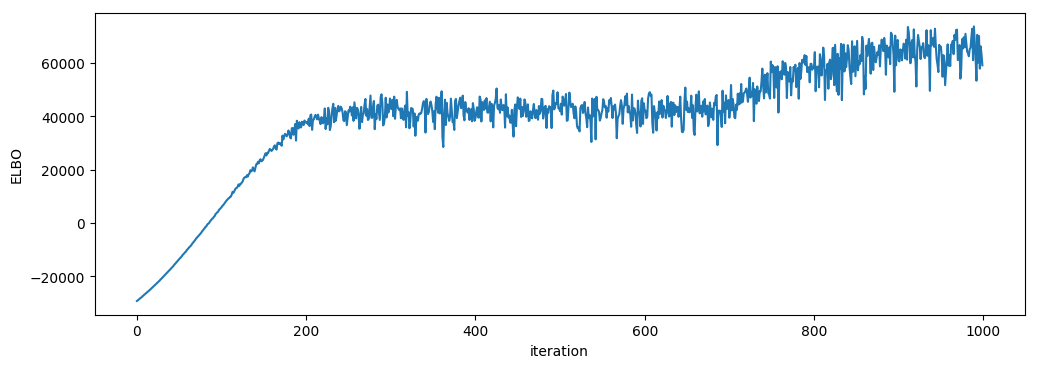

In [10]:
plt.plot(-np.array(logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [11]:
# predict
xtest = x[::3].copy()
mu_a, var_a, mu_c, var_c, m_src = m.predict_act_n_com(xtest)

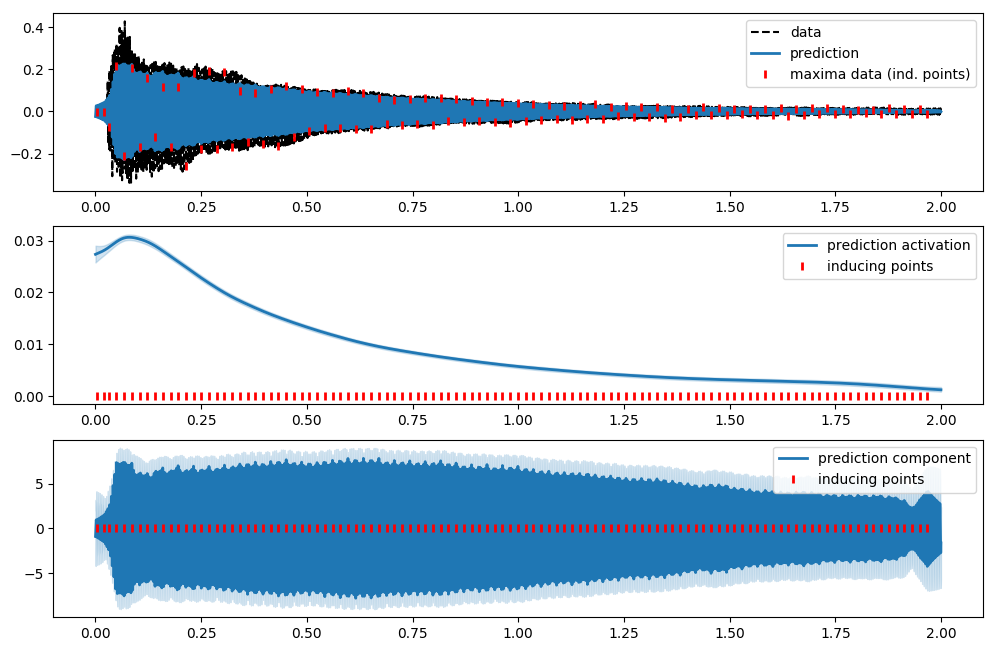

In [12]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(x, y, 'k--')
plt.plot(xtest, m_src[0], lw=2)
plt.plot(z[0][0], u, '|r', mfc="none", ms=6, mew=2)
plt.legend(['data', 'prediction', 'maxima data (ind. points)'])

plt.subplot(3, 1, 2)
plot_predict(x=xtest, mean=mu_a[0], var=var_a[0], z=m.za[0].value, latent=True)
plt.legend(['prediction activation', 'inducing points'], loc=1)

plt.subplot(3, 1, 3)
plot_predict(x=xtest, mean=mu_c[0], var=var_c[0], z=m.zc[0].value)
plt.legend(['prediction component', 'inducing points'], loc=1)
plt.savefig("demo-modgp.png")
plt.show()

In [13]:
m.kern_com

Name,values,prior,constraint
kern_com.item0.energy.item0,[ 4.01704532],None,+ve
kern_com.item0.energy.item1,[ 0.00050104],None,+ve
kern_com.item0.energy.item2,[ 0.00044095],None,+ve
kern_com.item0.energy.item3,[ 0.0005554],None,+ve
kern_com.item0.energy.item4,[ 0.00030197],None,+ve
kern_com.item0.frequency.item0,[ 252.84916422],None,+ve
kern_com.item0.frequency.item1,[ 525.54387585],None,+ve
kern_com.item0.frequency.item2,[ 785.16641217],None,+ve
kern_com.item0.frequency.item3,[ 1046.66450142],None,+ve
kern_com.item0.frequency.item4,[ 1307.71717549],None,+ve
